In [25]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import math


In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim):
        super().__init__()
        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [batch_size, embed_dim, num_patches_row, num_patches_row]
        x = x.flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        return x





In [27]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        # Q, K, V 的线性投影
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape
        qkv = self.qkv(x)  # [batch_size, num_tokens, embed_dim * 3]
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch_size, num_heads, num_tokens, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]

        # 注意力机制
        attn_scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [batch_size, num_heads, num_tokens, num_tokens]
        attn_probs = attn_scores.softmax(dim=-1)
        attn_output = (attn_probs @ v)  # [batch_size, num_heads, num_tokens, head_dim]

        # 合并头部
        attn_output = attn_output.permute(0, 2, 1, 3).reshape(batch_size, num_tokens, embed_dim)
        return self.out_proj(attn_output)



In [28]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # 自注意力层
        x = x + self.dropout(self.attn(self.norm1(x)))
        # 前向传播网络
        x = x + self.dropout(self.ffn(self.norm2(x)))
        return x



In [29]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=128, num_heads=4, depth=6, num_classes=2):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
      print(f"Input shape: {x.shape}")  # 打印输入形状
      batch_size = x.shape[0]
      x = self.patch_embed(x)  # [batch_size, num_patches, embed_dim]
      print(f"Patch Embedding output shape: {x.shape}")  # 打印 Patch Embedding 输出形状

      cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch_size, 1, embed_dim]
      print(f"CLS token shape: {cls_tokens.shape}")  # 打印 CLS token 的形状

      x = torch.cat((cls_tokens, x), dim=1)  # [batch_size, num_patches+1, embed_dim]
      print(f"Concatenated shape: {x.shape}")  # 打印拼接后的形状

      x = x + self.pos_embed  # [batch_size, num_patches+1, embed_dim]
      print(f"After adding positional embedding: {x.shape}")  # 打印加上位置嵌入后的形状

      for i, block in enumerate(self.blocks):
        x = block(x)
        print(f"After Transformer block {i + 1}: {x.shape}")  # 打印每个 Transformer block 后的形状

      x = self.norm(x)  # [batch_size, num_patches+1, embed_dim]
      print(f"After LayerNorm: {x.shape}")  # 打印 LayerNorm 后的形状

      cls_output = x[:, 0]  # 取分类 token
      print(f"CLS token output: {cls_output.shape}")  # 打印分类 token 的形状

      return self.head(cls_output)  # [batch_size, num_classes]



In [30]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder("C:\\Users\\YuXi Yuan\\Desktop\\dataaset", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VisionTransformer(img_size=224, patch_size=16, embed_dim=128, num_heads=4, depth=6, num_classes=2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

train_model(model, train_loader, epochs=10)


Input shape: torch.Size([4, 3, 224, 224])
Patch Embedding output shape: torch.Size([4, 196, 128])
CLS token shape: torch.Size([4, 1, 128])
Concatenated shape: torch.Size([4, 197, 128])
After adding positional embedding: torch.Size([4, 197, 128])
After Transformer block 1: torch.Size([4, 197, 128])
After Transformer block 2: torch.Size([4, 197, 128])
After Transformer block 3: torch.Size([4, 197, 128])
After Transformer block 4: torch.Size([4, 197, 128])
After Transformer block 5: torch.Size([4, 197, 128])
After Transformer block 6: torch.Size([4, 197, 128])
After LayerNorm: torch.Size([4, 197, 128])
CLS token output: torch.Size([4, 128])
Epoch 1, Loss: 0.4391
Input shape: torch.Size([4, 3, 224, 224])
Patch Embedding output shape: torch.Size([4, 196, 128])
CLS token shape: torch.Size([4, 1, 128])
Concatenated shape: torch.Size([4, 197, 128])
After adding positional embedding: torch.Size([4, 197, 128])
After Transformer block 1: torch.Size([4, 197, 128])
After Transformer block 2: torch.

以下是预测部分

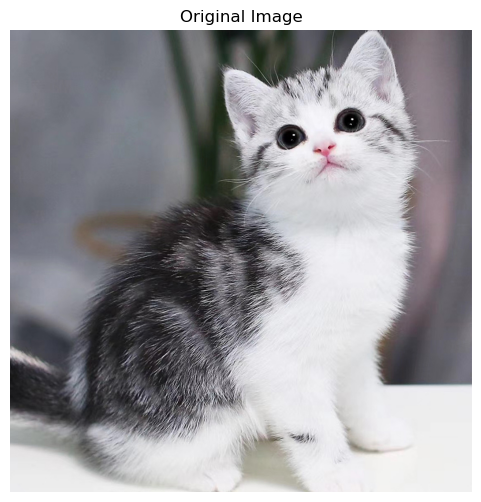

In [48]:
from PIL import Image
from torchvision import transforms

# 定义与训练一致的预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 确保图片大小与训练时一致
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 与训练时一致的归一化
])

# 加载图片并进行预处理
image_path = "C:\\Users\\YuXi Yuan\\Pictures\\cat-test.jpg"  
image = Image.open(image_path).convert("RGB")  # 确保图片是 RGB 格式
# 展示原始图片
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()
image = transform(image)  # 应用预处理
image = image.unsqueeze(0)  # 添加 batch 维度，形状变为 [1, 3, 224, 224]


In [33]:
import torch

# 确保模型在评估模式
model.eval()

# 将图片移到设备（CPU/GPU）
device = "cuda" if torch.cuda.is_available() else "cpu"
image = image.to(device)
model = model.to(device)

# 禁用梯度计算进行推理
with torch.no_grad():
    output = model(image)  # 模型的输出，形状为 [1, num_classes]
    predicted_class = torch.argmax(output, dim=1).item()  # 获取预测的类别索引

# 显示预测结果
print(f"Predicted class index: {predicted_class}")


Input shape: torch.Size([1, 3, 224, 224])
Patch Embedding output shape: torch.Size([1, 196, 128])
CLS token shape: torch.Size([1, 1, 128])
Concatenated shape: torch.Size([1, 197, 128])
After adding positional embedding: torch.Size([1, 197, 128])
After Transformer block 1: torch.Size([1, 197, 128])
After Transformer block 2: torch.Size([1, 197, 128])
After Transformer block 3: torch.Size([1, 197, 128])
After Transformer block 4: torch.Size([1, 197, 128])
After Transformer block 5: torch.Size([1, 197, 128])
After Transformer block 6: torch.Size([1, 197, 128])
After LayerNorm: torch.Size([1, 197, 128])
CLS token output: torch.Size([1, 128])
Predicted class index: 0


In [35]:
# 定义类别名称
class_names = ["cat", "dog"]  

# 输出预测的类别名称
print(f"Predicted class: {class_names[predicted_class]}")


Predicted class: cat


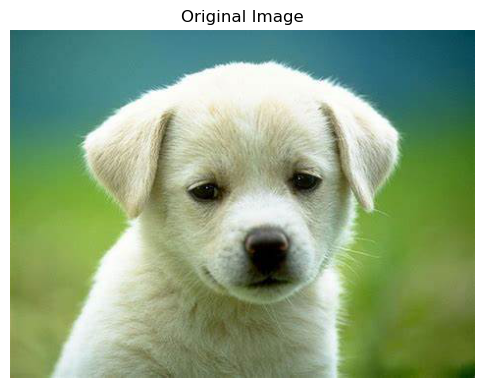

In [49]:
from PIL import Image
from torchvision import transforms

# 定义与训练一致的预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 确保图片大小与训练时一致
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 与训练时一致的归一化
])

# 加载图片并进行预处理
image_path = "C:\\Users\\YuXi Yuan\\Pictures\\dog-test4.jpg"  
image = Image.open(image_path).convert("RGB")  # 确保图片是 RGB 格式

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.show()

image = transform(image)  # 应用预处理
image = image.unsqueeze(0)  # 添加 batch 维度，形状变为 [1, 3, 224, 224]

In [45]:
import torch

# 确保模型在评估模式
model.eval()

# 将图片移到设备（CPU/GPU）
device = "cuda" if torch.cuda.is_available() else "cpu"
image = image.to(device)
model = model.to(device)

# 禁用梯度计算进行推理
with torch.no_grad():
    output = model(image)  # 模型的输出，形状为 [1, num_classes]
    predicted_class = torch.argmax(output, dim=1).item()  # 获取预测的类别索引

# 显示预测结果
print(f"Predicted class index: {predicted_class}")

Input shape: torch.Size([1, 3, 224, 224])
Patch Embedding output shape: torch.Size([1, 196, 128])
CLS token shape: torch.Size([1, 1, 128])
Concatenated shape: torch.Size([1, 197, 128])
After adding positional embedding: torch.Size([1, 197, 128])
After Transformer block 1: torch.Size([1, 197, 128])
After Transformer block 2: torch.Size([1, 197, 128])
After Transformer block 3: torch.Size([1, 197, 128])
After Transformer block 4: torch.Size([1, 197, 128])
After Transformer block 5: torch.Size([1, 197, 128])
After Transformer block 6: torch.Size([1, 197, 128])
After LayerNorm: torch.Size([1, 197, 128])
CLS token output: torch.Size([1, 128])
Predicted class index: 1


In [46]:
# 输出预测的类别名称
print(f"Predicted class: {class_names[predicted_class]}")

Predicted class: dog
